In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Hyperbolic Spaces

This notebook shows how define and evaluate kernels on the two-dimensional hyperbolic space $\mathbb{H}_2$.

Handling higher-dimensional hyperbolic spaces $\mathbb{H}_d$ for $d \geq 2$ is essentially the same.
We chose to showcase $\mathbb{H}_2$ here because (1) it is probably the most well known case (2) it is easy to visualize.

**Note:** the points on the hyperbolic space $\mathbb{H}_d$ are represented by $d+1$-dimensional vectors (`array`s of the suitable backend) satisfying $x_1^2 - x_2^2 - \ldots - x_{d+1}^2 = 1$ (i.e. lying on the hyperboloid).

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hyperbolic
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional hyperbolic space $\mathbb{H}_2$.

In [3]:
hyperbolic_space = Hyperbolic(dim=2)

## Defining a Kernel

To initialize `MaternGeometricKernel` you need to provide a `Space` object, in our case this is the `hyperbolic_space` we have just created above.
Additionally, there is a mandatory keyword argument `key` which should be equal to a random generator that is **specific to the backend you are using**.
This is because `MaternGeometricKernel` on non-compact symmetric spaces is a random Monte Carlo approximation. Notably, this implies that kernel can be (slightly) different every time.

There is also an optional parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on non-compact symmetric spaces (which hyperbolic spaces are instances of) can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/symmetric.html).

First, we define randomness

In [4]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [5]:
kernel = MaternGeometricKernel(hyperbolic_space, key=key)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [6]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array(inf), 'lengthscale': array(1.)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [7]:
params["lengthscale"] = np.array([1.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since hyperbolic spaces are noncompact, the sampling cannot be uniform.
Here we resort to the default sampling routine from the [geomstats](https://geomstats.github.io/index.html) package.

In [8]:
xs = hyperbolic_space.random_point(10)

print(xs)

[[ 1.10310368 -0.37039723 -0.28221202]
 [ 1.44994888  0.93587264  0.475914  ]
 [ 1.47698302  0.45840834 -0.98556615]
 [ 1.26041934  0.76707797 -0.01575773]
 [ 1.11097289 -0.10642687  0.47215896]
 [ 1.04201022 -0.19386863 -0.21954556]
 [ 1.16194596 -0.25576963 -0.53357315]
 [ 1.52521243 -0.80754976 -0.82105806]
 [ 1.1066993  -0.24917745  0.40335337]
 [ 1.50703687  0.77904108 -0.81501849]]


Now we evaluate the two kernel matrices.

In [9]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

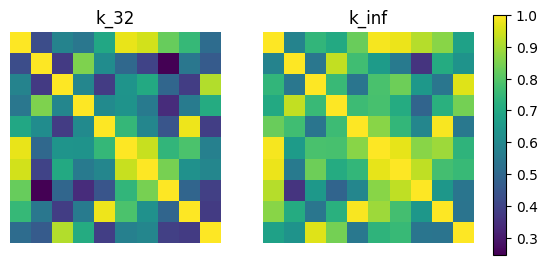

In [10]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The hyperbolic spaces $\mathbb{H}_2$ is one of the few manifolds we can visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(*, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
The `base_point` is the center of the Poincaré disk.
The `other_points` is defined as a grid thereon.
Here we exploit the fact that `Hyperbolic` inherits from `geomstats` [Hyperbolic](https://geomstats.github.io/_modules/geomstats/geometry/hyperbolic.html#Hyperbolic).

We define `base_point` and `other_points` in the next cell.

In [11]:
base_point = hyperbolic_space.from_coordinates(np.r_[0, 0], "intrinsic").reshape(1, 3)

s = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(s, s)
other_points = np.c_[xx.ravel(), yy.ravel()]
other_points = hyperbolic_space.from_coordinates(other_points, "intrinsic")

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [12]:
kernel_vals_32  = kernel.K(params_32,  base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, base_point, other_points)

Finally, we are ready to plot the results.

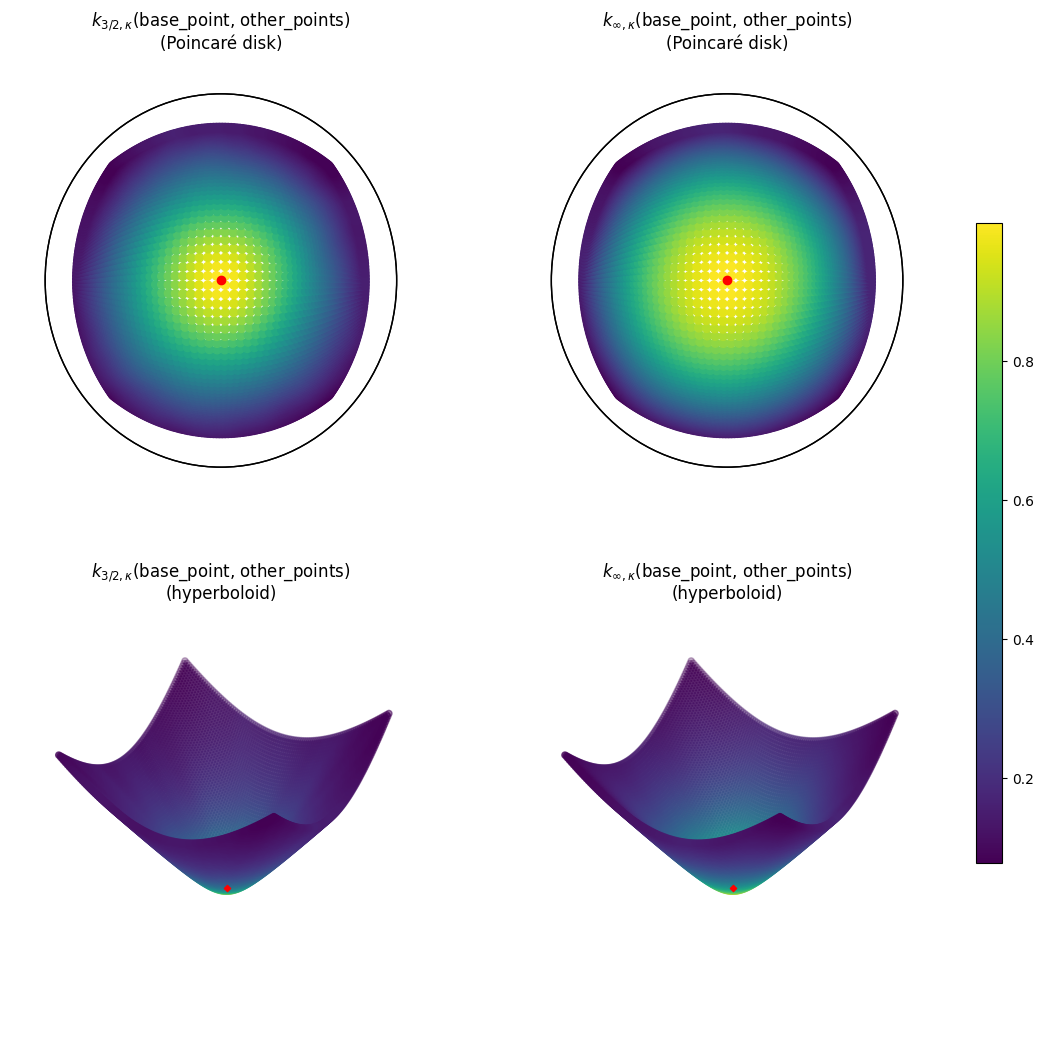

In [13]:
# fig, (ax1, ax2) = plt.subplots(figsize= (10, 10), nrows=2, ncols=2)
fig = plt.figure(figsize=(12.8, 12.8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, projection='3d', computed_zorder=False)
ax4 = fig.add_subplot(2, 2, 4, projection='3d', computed_zorder=False)

cmap = plt.get_cmap('viridis')

visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_32,  cmap=cmap, ax=ax1)
visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_inf, cmap=cmap, ax=ax2)
ax3.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=kernel_vals_32[0], cmap=cmap)
ax4.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=kernel_vals_inf[0], cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3._axis3don = False
ax4._axis3don = False

# plot the base point
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax1)
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax2)
ax3.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')
ax4.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

# add space for color bar
ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(Poincaré disk)')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(Poincaré disk)')
ax3.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(hyperboloid)')
ax4.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(hyperboloid)')

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the hyperbolic space, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).
**Note:** for non-compact symmetric spaces like the hyperbolic space, the kernel is always evaluated via a feature map under the hood.

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [14]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(hyperbolic_space, kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs, parameters of the kernel and the JAX-style randomness parameter.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the hyperbolic space, `normalize` is `True` by default.

`feature_map` outputs a tuple.
Its first element is $\phi(x)$ evaluated at all inputs $x$.
Its second element is the context dict.
The latter is either empty or contains the updated random key for randomized feature maps (as in our case).

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [15]:
# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# xs are random points from above
embedding, _ = feature_map(xs, params_32, key)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 3)):
[[ 1.10310368 -0.37039723 -0.28221202]
 [ 1.44994888  0.93587264  0.475914  ]
 [ 1.47698302  0.45840834 -0.98556615]
 [ 1.26041934  0.76707797 -0.01575773]
 [ 1.11097289 -0.10642687  0.47215896]
 [ 1.04201022 -0.19386863 -0.21954556]
 [ 1.16194596 -0.25576963 -0.53357315]
 [ 1.52521243 -0.80754976 -0.82105806]
 [ 1.1066993  -0.24917745  0.40335337]
 [ 1.50703687  0.77904108 -0.81501849]]

emedding (shape = (10, 6000)):
[[ 0.01853271  0.01376589  0.01737896 ... -0.01652587  0.00271829
  -0.00112042]
 [ 0.01461993  0.0184959   0.00917968 ...  0.00943595  0.00379301
   0.01185007]
 [ 0.02905609  0.01946905  0.00013563 ... -0.02314635  0.00786397
  -0.0266481 ]
 ...
 [ 0.01790273  0.00620389  0.0095189  ... -0.02402641  0.00686584
   0.00177875]
 [ 0.01448361  0.01330745  0.016558   ...  0.01360786 -0.00800991
   0.01193636]
 [ 0.02682646  0.01730914 -0.00060056 ... -0.00697139  0.00785946
  -0.02678178]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 0.0


## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples, the kernel parameters and the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [16]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[-0.37850243 -0.10772868]
 [ 0.23722238  0.15966568]
 [-0.47398782 -0.64547031]
 [ 0.14333301  0.1989107 ]
 [-0.76839736  0.09124135]
 [-0.50419473 -0.04574942]
 [-0.50552879 -0.17144583]
 [ 0.08251383 -0.29241361]
 [-0.76031791  0.2383049 ]
 [-0.14988905 -0.76674153]]


### Visualizing Samples
Here we visualize samples as functions on the hyperbolic space.

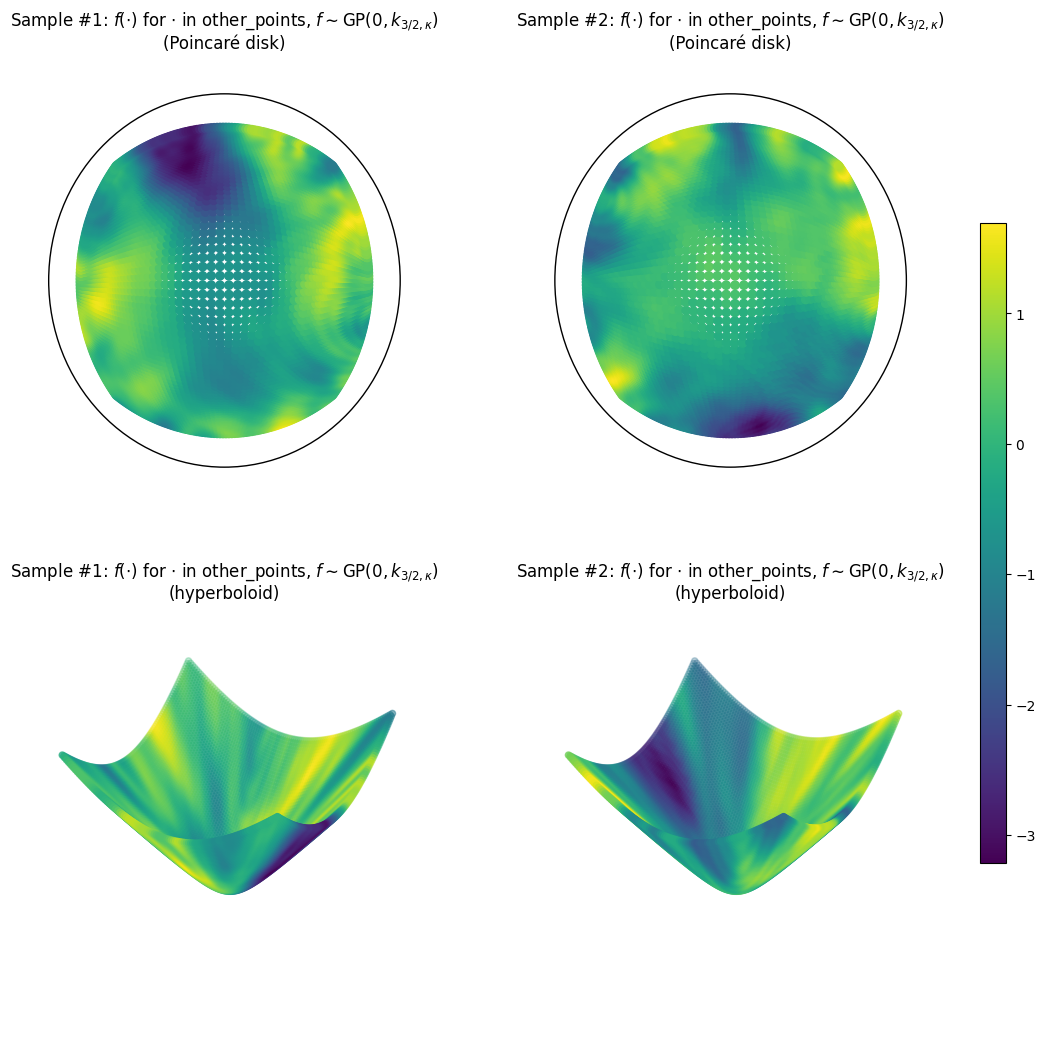

In [17]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

fig = plt.figure(figsize=(12.8, 12.8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, projection='3d', computed_zorder=False)
ax4 = fig.add_subplot(2, 2, 4, projection='3d', computed_zorder=False)

cmap = plt.get_cmap('viridis')

visualization.plot(other_points, space="H2_poincare_disk", c=sample1, cmap=cmap, ax=ax1)
visualization.plot(other_points, space="H2_poincare_disk", c=sample2, cmap=cmap, ax=ax2)
ax3.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=sample1, cmap=cmap)
ax4.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=sample2, cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3._axis3don = False
ax4._axis3don = False

# find common range of values
minmin_vis = np.min([np.min(sample1), np.min(sample2)])
maxmax_vis = np.max([np.max(sample1), np.max(sample2)])

# add space for color bar
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$'   '\n(Poincaré disk)')
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$' '\n(Poincaré disk)')
ax3.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$'   '\n(hyperboloid)')
ax4.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$' '\n(hyperboloid)')

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using hyperbolic spaces and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```